In [1]:
import json
import pandas as pd
import numpy as np
import string 
import csv
import os
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from summa import keywords,summarizer
from ast import literal_eval

## Reading data

In [2]:
data = [json.loads(line) for line in open('ads-50k.json', 'r')]   #reading ads json data
keys = set().union(*(d.keys() for d in data))
with open('ads.csv', 'w', newline='') as output_file:        #transforming json data to csv table using keys
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(data) #saving to csv

In [3]:
ads = pd.read_csv(f"ads.csv")    
events = pd.read_csv(f"ads-50k-events.csv")  #reading events data

## Initial data cleaning

In [4]:
ads.metadata = ads.metadata.apply(literal_eval)    #converting stringed dictionary to a Python dictionary

In [5]:
ads = ads.join(pd.json_normalize(ads.pop('metadata'))) #transforming Python dict to feature columns

In [6]:
ads['content'] = ads['content'].str.replace(r'<[^<>]*>', ' ', regex=True)  #deleting HTML tags from content column
ads['content'] = ads['content'].str.replace(r'&[^<>]*;', ' ', regex=True)
ads['content'] = ads['content'].str.replace('\n', ' ')

In [7]:
ads = ads.drop_duplicates()     #deleting duplicates
events = events.drop_duplicates()

## Merging data

In [8]:
ads = ads.rename(columns = {'id': 'job_id'})  #renaming column for merge

In [9]:
df = ads.merge(events, on='job_id', how='outer') #merging datasets

In [10]:
df.isna().sum() #some missing data but not in the key areas (however, it would be good to have proper salary data)

abstract                       0
job_id                         0
content                        0
title                          0
additionalSalaryText      964010
standout.bullet1          665892
standout.bullet2          665892
standout.bullet3          665892
classification.name            0
subClassification.name         0
location.name                  0
workType.name                  0
area.name                 493549
suburb.name               376280
event_datetime                 0
resume_id                      0
event_platform                 0
kind                           0
dtype: int64

In [11]:
df['event_datetime'] = pd.to_datetime(df['event_datetime']) #transform datetime column to datetime

## Data Analysis 
### Datetime data

In [12]:
df['hour'] = df['event_datetime'].dt.hour

<AxesSubplot:>

<Figure size 720x432 with 0 Axes>

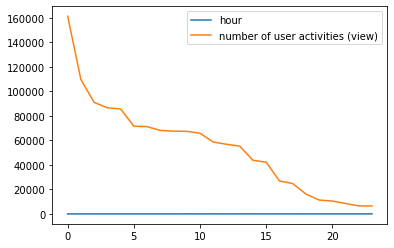

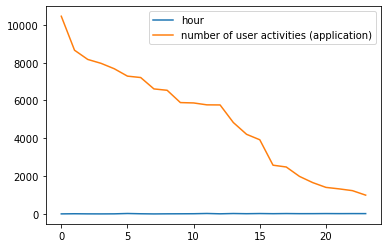

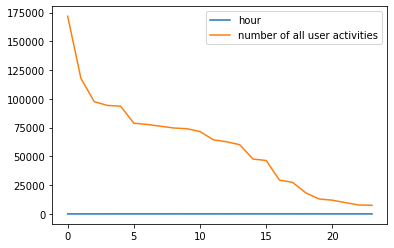

In [13]:
V_event = df[df['kind']=='V']
A_event = df[df['kind']=='A']
plt.figure(figsize=(10,6))

V_event.groupby(['hour']).size().sort_values(ascending=False).reset_index(name='number of user activities (view)').plot()
A_event.groupby(['hour']).size().sort_values(ascending=False).reset_index(name='number of user activities (application)').plot()
df.groupby(['hour']).size().sort_values(ascending=False).reset_index(name='number of all user activities').plot()

#Date - 01.05.2021 - Saturday 
#to be asked: is it one timezone or a local timezone? why are so many events around 1-2 AM? 
#people view and apply mostly during the night on weekend?

### Analysing all features

#### After merging Job Ads and Events data we receive a dataset containing following information:

Job Ads data: 
- Title (Ad Title, Text)
- Job ID (number)
- Content (Job Description, Text)
- Abstract (Job Description, short,  Text)
- Additional Salary (Extra salary details, Text)
- Bullet1, Bullet2, Bullet3 (Job Promo, Text)
- Classification/SubClassification (Job Classification, type)
- Location/SubUrb/Area (location, Text)
- WorkType (Work Type, Text)

Events data:
- DateTime 
- Resume ID (number)
- Platform (Web, Android etc.)
- Kind (View/Application)

In [14]:
for col in df.columns:   #basic statistics of columns without NLP processing
    print(df.groupby([col])[col].size().sort_values(ascending=False).reset_index(name='count'))

                                                abstract  count
0      Teachers at range 1 are responsible for teachi...    673
1      Step up to an action-packed Navy role, maintai...    648
2      Whether they’re racing to fill shelves or scan...    615
3                                                      .    559
4      Join a leading Life, Health & Wellness organis...    545
...                                                  ...    ...
46047  Exciting opportunity for experienced Site Mana...      1
46048  Fulton Hogan are currently looking for an expe...      1
46049  RSL LifeCare At Home is seeking Home Care spec...      1
46050  RSP are seeking a Purchasing Officer to join o...      1
46051  Manage complex tasks and prioritising of activ...      1

[46052 rows x 2 columns]
         job_id  count
0      38835280    389
1      38974633    389
2      38971697    389
3      38892785    389
4      38929331    389
...         ...    ...
49995  38994512      1
49996  38928625      1

In [15]:
#Analysing most common industry - IT
df[df['classification.name']=='Information & Communication Technology'].groupby(['subClassification.name'])['subClassification.name'].size().sort_values(ascending=False).reset_index(name='count')

,subClassification.name,count
0,Developers/Programmers,31273
1,Business/Systems Analysts,20007
2,Programme & Project Management,14326
3,Engineering - Software,11157
4,Help Desk & IT Support,9867
5,Networks & Systems Administration,8161
6,Consultants,7572
7,Other,6935
8,Architects,6708
9,Testing & Quality Assurance,6507


In [16]:
df.head(5)

,abstract,job_id,content,title,additionalSalaryText,standout.bullet1,standout.bullet2,standout.bullet3,classification.name,subClassification.name,location.name,workType.name,area.name,suburb.name,event_datetime,resume_id,event_platform,kind,hour
0,We are looking for someone to focus purely on ...,38915469,Are you looking to join a thriving business ...,Recruitment Consultant,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN,2021-05-01 21:45:58,45311,WEB,V,21
1,We are looking for someone to focus purely on ...,38915469,Are you looking to join a thriving business ...,Recruitment Consultant,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN,2021-05-01 22:21:19,278497,WEB,V,22
2,We are looking for someone to focus purely on ...,38915469,Are you looking to join a thriving business ...,Recruitment Consultant,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN,2021-05-01 00:22:44,357,IOS_APP,V,0
3,We are looking for someone to focus purely on ...,38915469,Are you looking to join a thriving business ...,Recruitment Consultant,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN,2021-05-01 00:00:07,1,IOS_APP,V,0
4,We are looking for someone to focus purely on ...,38915469,Are you looking to join a thriving business ...,Recruitment Consultant,commission,Join a Sector that is considered Recession Pro...,Excellent opportunity for Career Progression ...,Make a Diference whilst earning Money and havi...,Education & Training,Other,Sydney,Full Time,NaN,NaN,2021-05-01 01:38:37,183444,IOS_APP,V,1


### Basic statistics, interesting insights and possible problems

Job Ads data:
- Title - contains unique values, need for keyword extraction, most popular roles are in Management
- Job ID - some jobs have 389 events, some only 1 (more and less popular jobs?)
- Content - missing content (whitespaces), unique content, need for keyword extraction
- Abstract - unique content, need for keyword extraction
- Additional Salary - unique content, need for keyword extraction (benefits feature) and salary range extraction (preferably all numbers calculated as yearly salary since units are per hour, year and day)
- Bullet1, Bullet2, Bullet3 - missing content (whitespaces), unique content, need for keyword extraction, common “Immediate Start” 
- Classification/SubClassification - 30 categories (mostly IT and Healthcare), 337 subcategories (mostly Management)
- Location - 87 categories sometimes are overlapping, large range of unit sizes (eg. Sydney, Rest of the UK, Europe & Russia), mostly Sydney and Melbourne
- Area - 69 categories sometimes are overlapping, large range of unit sizes (eg. South Asia, CBD & Inner Suburbs, CBD, Inner West & Eastern Suburbs), mostly CBD and inner suburbs
- Suburb - 2546 categories sometimes are overlapping, large range of unit sizes, mostly Sydney and Melbourne, overlapping with Location information
- WorkType - 4 categories (mostly full-time)

Events data:
- DateTime - is it one timezone or a local timezone? Many events around 1-2 AM (why?)
- Resume ID - some people have more than 3000 events, some only 1 (less or more active users)
- Platform - 3 categories (mostly web)
- Kind - 2 categories (mostly viewing)


## Features consolidation for AI and dropping

In [17]:
df = df[df['kind']=='A'] #decided to keep only "Applied" roles as they indicate the best match for a candidate
#another option could be keeping also offers that were "Viewed" multiple times (multiple events)

In [18]:
NLP_columns = ['title',  'content', 'abstract', 'additionalSalaryText',
       'standout.bullet1', 'standout.bullet2', 'standout.bullet3'] 
#columns where keywords should be extracted (and salary value)
for col in NLP_columns:
    df[col] = df[col].fillna('').astype(str) #replace NaN with an empty string

In [19]:
df['all_content'] = df[['content', 'abstract','standout.bullet1', 'standout.bullet2', 'standout.bullet3']].apply(" ".join, axis=1)
df = df.drop(['content','abstract','standout.bullet1', 'standout.bullet2', 'standout.bullet3'], axis=1) #merge keyword columns
df = df.drop(['area.name', 'suburb.name','kind','event_platform','event_datetime','hour'], axis=1) 
#dropping two location-related features for the simplicity of analysis. 
#TBD: data consolidation and cleaning between all 3 columns

In [20]:
df.head(5)

,job_id,title,additionalSalaryText,classification.name,subClassification.name,location.name,workType.name,resume_id,all_content
40,38915469,Recruitment Consultant,commission,Education & Training,Other,Sydney,Full Time,185118,Are you looking to join a thriving business ...
64,38934839,Computers Salesperson - Coburg,Attractive Commission - Uncapped Earning Poten...,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,298955,A flexible and positive work environment ...
65,38934839,Computers Salesperson - Coburg,Attractive Commission - Uncapped Earning Poten...,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,298955,A flexible and positive work environment ...
79,38934839,Computers Salesperson - Coburg,Attractive Commission - Uncapped Earning Poten...,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,3546,A flexible and positive work environment ...
88,38934839,Computers Salesperson - Coburg,Attractive Commission - Uncapped Earning Poten...,Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,7496,A flexible and positive work environment ...


## Natural Language Processing - basic keyword extraction

- TextRank implementation for text summarization and keyword extraction with optimizations on the similarity function
- Content and Title probably have salary information but for this analysis I decided to simplify assumptions

In [21]:
df['all_content'] = df['all_content'].apply(lambda row: summarizer.summarize(row, words=100))  #longest text summarization

In [22]:
df['all_content'] = df['all_content'].apply(lambda row: keywords.keywords(row, ratio=0.5).replace('\n',' ').split())  #keywords retriecal

In [23]:
df['title_keywords'] = df['title'].apply(lambda row: keywords.keywords(row, ratio=0.9).replace('\n',' ').split())  #keywords retriecal

In [24]:
#df['additionalSalaryText'] = df['additionalSalaryText'].apply(lambda row: keywords.keywords(row, ratio=0.8).replace('\n',' ').split())    #keywords retrieval
#extracting benefits, for the future TBD: extracting and cleaning salary (so it is in the same range)

In [25]:
features = ['title_keywords', 'classification.name', 'subClassification.name', 'location.name', 'workType.name', 'all_content']

In [26]:
df[features].head(5)

,title_keywords,classification.name,subClassification.name,location.name,workType.name,all_content
40,[recruitment],Education & Training,Other,Sydney,Full Time,"[focus, purely, permanent, staff, recruiting, ..."
64,"[salesperson, coburg]",Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,"[positive, work, environment, role, exhilarate..."
65,"[salesperson, coburg]",Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,"[positive, work, environment, role, exhilarate..."
79,"[salesperson, coburg]",Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,"[positive, work, environment, role, exhilarate..."
88,"[salesperson, coburg]",Retail & Consumer Products,Retail Assistants,Melbourne,Casual/Vacation,"[positive, work, environment, role, exhilarate..."


In [55]:
df

,Unnamed: 0,job_id,title,additionalSalaryText,classification.name,subClassification.name,location.name,workType.name,resume_id,all_content,title_keywords,soup
5958,78929,38868348,Data Scientist,Attractive Salary Package,information&communicationtechnology,consultants,sydney,fulltime,153907,"['experience', 'work', 'working', 'data', 'tea...",['data'],data data experience work working data team de...
5959,78936,38868348,Data Scientist,Attractive Salary Package,information&communicationtechnology,consultants,sydney,fulltime,245,"['experience', 'work', 'working', 'data', 'tea...",['data'],data data experience work working data team de...
45422,546540,38899756,Data Scientist,NaN,information&communicationtechnology,productmanagement&development,perth,fulltime,3752,"['coding', 'code', 'good', 'write', 'advance',...",['data'],data data coding code good write advance excel...
45423,546541,38899756,Data Scientist,NaN,information&communicationtechnology,productmanagement&development,perth,fulltime,3752,"['coding', 'code', 'good', 'write', 'advance',...",['data'],data data coding code good write advance excel...
45424,546542,38899756,Data Scientist,NaN,information&communicationtechnology,productmanagement&development,perth,fulltime,3752,"['coding', 'code', 'good', 'write', 'advance',...",['data'],data data coding code good write advance excel...
45425,546551,38899756,Data Scientist,NaN,information&communicationtechnology,productmanagement&development,perth,fulltime,3272,"['coding', 'code', 'good', 'write', 'advance',...",['data'],data data coding code good write advance excel...
45426,546564,38899756,Data Scientist,NaN,information&communicationtechnology,productmanagement&development,perth,fulltime,11393,"['coding', 'code', 'good', 'write', 'advance',...",['data'],data data coding code good write advance excel...
79245,942151,38924510,Data Scientist,Excellent Daily Rate,information&communicationtechnology,databasedevelopment&administration,melbourne,contract/temp,68934,"['profile', 'candidate', 'highlight', 'industr...",['data'],data data profile candidate highlight industry...
79246,942154,38924510,Data Scientist,Excellent Daily Rate,information&communicationtechnology,databasedevelopment&administration,melbourne,contract/temp,67851,"['profile', 'candidate', 'highlight', 'industr...",['data'],data data profile candidate highlight industry...
79247,942156,38924510,Data Scientist,Excellent Daily Rate,information&communicationtechnology,databasedevelopment&administration,melbourne,contract/temp,8065,"['profile', 'candidate', 'highlight', 'industr...",['data'],data data profile candidate highlight industry...


## One user analysis

In [27]:
df[df['resume_id']==185118].head(5) #Does one user has only one resume or multiple?
#This particular user applied for a big variety of jobs

,Unnamed: 0,job_id,title,additionalSalaryText,classification.name,subClassification.name,location.name,workType.name,resume_id,all_content,title_keywords,soup
70,1043,39001112,Carers - Benhome (Maitland),NaN,healthcare&medical,nursing-agedcare,"newcastle,maitland&hunter",casual/vacation,245,"['right', 'role', 'team', 'organisation', 'wai...","['benhome', 'maitland']",benhome maitland benhome maitland right role t...
128,1864,38836868,"Analyst, Investments Monitoring",NaN,banking&financialservices,compliance&risk,melbourne,fulltime,245,"['internal', 'investments', 'help', 'invest', ...","['investments', 'monitoring']",investments monitoring investments monitoring ...
328,4581,38981147,Receptionist / Administrator,NaN,administration&officesupport,receptionists,hawkesbay,fulltime,245,"['great', 'opportunity', 'sounds', 'like', 'st...",['receptionist'],receptionist receptionist great opportunity so...
330,4616,38829035,Site Manager,NaN,"manufacturing,transport&logistics",management,sydney,fulltime,245,"['strong', 'work', 'working', 'customer', 'rel...",['site'],site site strong work working customer relatio...
448,6182,38953452,Civil Estimator | VicRoads,140000,construction,estimating,melbourne,fulltime,245,[],"['estimator', 'vicroads']",estimator vicroads estimator vicroads 1 4 0 0...


In [28]:
user_applications = df[df['resume_id']==185118][['title','job_id','classification.name','subClassification.name','location.name','workType.name','all_content','title_keywords']]

In [ ]:
user_applications.head(5)

,index,title,job_id,classification.name,subClassification.name,location.name,workType.name,all_content,title_keywords
65,5959,Data Scientist,38868348,information&communicationtechnology,consultants,sydney,fulltime,"['experience', 'work', 'working', 'data', 'tea...",['data']


In [30]:
user_jobs = user_applications.job_id

In [31]:
for col in ['title','classification.name','subClassification.name','location.name','workType.name']:   #basic statistics of user job applications 
    print(user_applications.groupby([col])[col].size().sort_values(ascending=False).reset_index(name='count').head(3))

                             title  count
0           Contract Administrator      5
1  Customer Service Representative      5
2                 Business Analyst      5
                   classification.name  count
0                   healthcare&medical    108
1                      trades&services     98
2  information&communicationtechnology     84
             subClassification.name  count
0                             other     63
1  salesrepresentatives/consultants     26
2                        management     25
  location.name  count
0        sydney    272
1     melbourne    206
2      brisbane     78
   workType.name  count
0       fulltime    627
1  contract/temp    171
2       parttime     64


## Preparing data for ML model

In [32]:
def clean_data(x):         #preparing data for the modelling 
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

for feature in features:
    df[feature] = df[feature].apply(clean_data) 

In [33]:
def create_soup(x): #adding title keywords twice to increase weights
    return ' '.join(x['title_keywords']) + ' ' + ' '.join(x['title_keywords']) +  ' '  + ' '.join(x['all_content'])  + ' '  + ' '.join(x['additionalSalaryText']) + ' ' + x['classification.name'] + ' ' + x['subClassification.name'] +  ' ' + x['location.name'] + ' ' + x['workType.name'] 

In [34]:
df['soup'] = df.apply(create_soup, axis=1)

In [35]:
df.to_csv('final_data.csv') #saving data for future usage

In [36]:
df = pd.read_csv('final_data.csv')    

In [37]:
df[['title','title_keywords','all_content']].sample(10)

,title,title_keywords,all_content
64301,Building Services Engineering Drafter (Revit) ...,"['revit', 'services', 'engineering', 'drafter'...","['engineering', 'darwin', 'excellent', 'career..."
78931,Administration Assistant – Uniting Preschool W...,"['assistant', 'bexley', 'uniting', 'west', 'pr...","['pre', 'bexley', 'west', 'uniting', 'opportun..."
5269,Lead Educator,['lead'],[]
2574,Protection and Metering Apprentice,['metering'],"['powerlink', 'queensland', 'owns', 'develop',..."
110844,Mortgage Broker,['mortgage'],"['brokers', 'mentoring', 'comprehensive', 'mor..."
69626,BICYCLE MECHANIC - CARNEGIE VIC,"['mechanic', 'carnegie', 'vic']","['bicycle', 'trek', 'bikes', 'best', 'high', '..."
39684,Principal Geotechnical Engineer - Underground,"['geotechnical', 'engineer', 'underground']","['opportunity', 'opportunities', 'mines', 'cla..."
68245,Laboratory Assistants,['laboratory'],"['team', 'opportunity', 'sgs', 'airport', 'rep..."
2475,Senior Project Engineer,"['project', 'engineer']","['coordination', 'responsibilities', 'site', '..."
105747,Business Analyst - Christchurch,"['analyst', 'christchurch']","['business', 'delivering', 'smarter', 'helping..."


## The user case with examples - simple recommendation system


### Content-based recommender
- Suggesting similar items based on a particular item. This system uses job ad metadata (title, salary info, classification, location, type of work etc.), to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular job, he or she will also like a job that is similar to it. And to recommend that, it will make use of the user's past item metadata (a job that he/she applied to).

In [38]:
CHOSEN_COLS = ['job_id', 'title', 'resume_id', 'soup','title_keywords']

In [39]:
test_df = pd.concat([df.head(15000), df[df['job_id'].isin(user_jobs)]]).reset_index().drop_duplicates(subset=['index']).reset_index(drop=True)[CHOSEN_COLS] 
#taking testing piece of data, making sure all user data are in place

In [40]:
count = CountVectorizer() #converting a collection of text documents to a matrix of token counts
count_matrix = count.fit_transform(test_df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix) 
#cosine similarity, or the cosine kernel, computes similarity as the normalized dot product of X and Y

### Recommendation system
- This system recommend job advertisments based on one offer the person with resume ID 185118 applied 

In [134]:
user_jobs.reset_index().loc[0][1] #choosing one advertisment of user's choice

39001112

In [135]:
test_df[test_df['job_id']==user_jobs.reset_index().loc[0][1]] #about the offer

,job_id,title,resume_id,soup,title_keywords,similarity
68,39001112,Carers - Benhome (Maitland),71896,benhome maitland benhome maitland right role t...,"['benhome', 'maitland']",0.0
69,39001112,Carers - Benhome (Maitland),36855,benhome maitland benhome maitland right role t...,"['benhome', 'maitland']",0.0
70,39001112,Carers - Benhome (Maitland),245,benhome maitland benhome maitland right role t...,"['benhome', 'maitland']",0.0
71,39001112,Carers - Benhome (Maitland),9668,benhome maitland benhome maitland right role t...,"['benhome', 'maitland']",0.0
72,39001112,Carers - Benhome (Maitland),6625,benhome maitland benhome maitland right role t...,"['benhome', 'maitland']",0.0


In [136]:
test_df = test_df.reset_index(drop=True)
indices = pd.Series(test_df.index, index=test_df['job_id']) 
test_df['similarity'] = cosine_sim[0]  #adding similarity to the df

In [137]:
def get_recommendations(job_id, cosine_sim):  #preparing recommendation function
    idx = indices[job_id]
    print('Applied: ', test_df['title'][idx])
    try:
        scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:50]
        movie_indices = [i[0] for i in sim_scores]
        return test_df[["title","job_id","similarity"]].iloc[movie_indices].drop_duplicates(), scores
    except: 
        print('no roles')

## Comparing user choices and recommendations

In [138]:
recomm, scores = get_recommendations(38915469, cosine_sim)  #searching for a similar job offers as the job offer with ID 38915469 
recomm['type'] = 'recommendation'
recomm[1:].head(5) #recommendations for job offer with ID 38915469

Applied:  Recruitment Consultant


,title,job_id,similarity,type
675,"Recruitment Consultant, Sydney, up to $90k + S...",38869163,0.471405,recommendation
3684,Recruitment Manager,38927378,0.461935,recommendation
5961,Graduate Recruitment Consultant,38899421,0.458831,recommendation
722,Recruiter,38870142,0.416667,recommendation
2325,Recruitment Specialist - Mine Services,38958937,0.415168,recommendation


In [46]:
user_choices = test_df[test_df['job_id'].isin(user_jobs)].index
choices = test_df[test_df.index.isin(user_choices)][["title","job_id","similarity"]].sort_values(ascending=False, by='similarity') #choices
choices['type'] = 'user choice'
choices[1:].head(5) #job offer with user's applications

,title,job_id,similarity,type
15000,Teacher Electrotechnology,38833388,0.257674,user choice
15019,Drama/Humanities/Generalist Classroom Teacher,38934121,0.150970,user choice
15016,OSHC Coordinator - Tullamarine,38803241,0.144338,user choice
15003,Casual Educators - Brand new service!,38828974,0.132020,user choice
15004,Office Administrator,38818197,0.108148,user choice


In [47]:
compare_df = pd.concat([recomm,choices]).sort_index()
compare_df['type'].loc[0] = 'user choice - recommendation base' #tagging job offer with ID 38915469 (base offer)

/Users/magdalenakortas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [48]:
compare_df.sample(5)

,title,job_id,similarity,type
15023,Casual Café All-rounder in North Rocks,38966973,0.041030,user choice
3684,Recruitment Manager,38927378,0.461935,recommendation
15017,Home Care Worker,38923217,0.000000,user choice
14095,Credit Service Account Officer,38931580,0.034752,user choice
675,"Recruitment Consultant, Sydney, up to $90k + S...",38869163,0.471405,recommendation


In [49]:
cos_sim_data = pd.DataFrame(cosine_sim)
viz = cos_sim_data[cos_sim_data.index.isin(compare_df.index)][compare_df.index].sort_index() #preparing data for visualisation

#### K-means - clustering job offers
- The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.
- A clusters refer to a collection of data points aggregated together because of certain similarities.

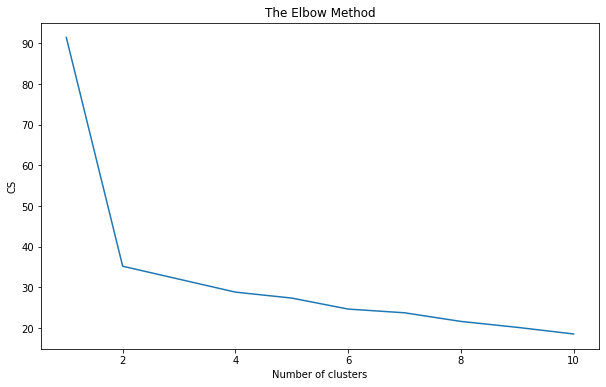

In [50]:
cs = []  
#choosing number of clusters with Elbow Method - plotting the explained variation as a function of the number of clusters and 
#picking the elbow of the curve as the number of clusters to use
plt.figure(figsize=(10,6))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(viz)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

#### PCA - Dimensionality reduction for visualisation
- Dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set

In [51]:
pca = PCA(2)
transform = pca.fit_transform(viz) #retrieving features with PCA

#### K-means Clustering and Visualisation

In [52]:
kmeans = KMeans(n_clusters= 2) #predict the labels of clusters
label = kmeans.fit_predict(transform) #getting unique labels
u_labels = np.unique(label)

In [53]:
data={'Name':compare_df['title'],'Cluster':label}   #preparing data to be displayed
clustering_data=pd.DataFrame(data)
clustering_data['type']=compare_df['type']
clustering_data['x'] = pd.DataFrame(transform)[0].values
clustering_data['y'] = pd.DataFrame(transform)[1].values
clustering_data = clustering_data.reset_index()

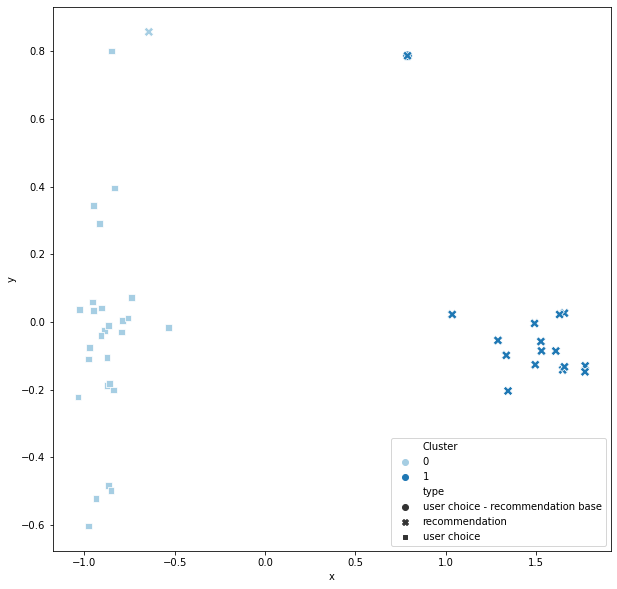

In [54]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="x", y="y", hue="Cluster", #visualisation
                data=clustering_data, palette='Paired', style="type", s=90);
plt.legend(loc='lower right');

## Summary: 
- There are fewer and more popular job ads: some get almost 400 events, some only 1
- Some people are more and some less active. The most active user has 3000 events while some have only 1. 
- There are more than 30.000 resumes. 
- Only one day of data (01.05.2021) - Saturday
- Big amount of events in the night (1-2 AM) - but some people just view and apply during the day
- Title is probably the most important feature for matchmaking and recruiters, contains unique values (need for keywords extraction), not-related information (salaries) and special signs (need for data cleaning)
- Most popular roles (without keyword extraction) are in Management or Healthcare (Business Development Manager 0.3%, Project Manager 0.3%, Nurse 0.2%)
- All features have some missing content, unique content (need for keyword extraction) or dirty content (like HTML tags)
- Quite popular information used in Bullet points is "Immediate Start" 
- Some other information in Content is related to eg. the type of role (permanent), salaries, location (need to extract)
- Content contains job requirements but is usually long and not user friendly
- Additional Salary is probably the dirtiest column - contains benefits, and salaries in different ranges (per hour, monthly, daily, annual), unique content, need for keyword extraction (benefits tags). 
- 3 columns describing similar information: location. The Location has 87 categories, Area - 69 and Suburb - more than 2500. Quite often - unique ones, in each and all columns information is often overlapping with a large range of units. You can find Sydney, Rest of UK, Europe & Russia in one column, the most common locations are Sydney - 26%, Melbourne - 21%, Brisbane - 9% with CBD suburbs-
- Work type has 4 categories. The most popular work type is Fulltime - 70% or Contract/Temp - 17%
- There are 3 categories of platforms. There is similar usage of Web and Mobile channels in all events 
- People usually view the offer many times before applying. Only 8% of events are applications. 
- There are 30 categories of classification and the most popular are IT - 11%, Healthcare - 9% and Trades - 9%
- There are almost 340 subcategories - most are shown as "Other" or management. 

#### The system

- For the simplicity of the example: Roles that a user applied for to see the best match, only 15.000 examples of matches, ignored salary information, only location data source (without cleaning), keywords extracted from Title, Content, Abstract, Bullet Points, Salary (benefits), Classification, SubClassification, Location, WorkType

- User Case: Resume ID 185118 (an user) applied for 28 jobs. Mostly in Education&Training or Retail&Consumer, in Melbourne or Sydney and preferably Full Time. We take one job (Job ID 38915469, Recruitment Consultant) the user applied for from Education&Training and recommend something similar. The system uses job ad metadata keywords (Keywords extracted from Title, Content, Abstract, Bullet Points, Salary (benefits), Classification, SubClassification, Location, WorkType) and cosine similarity to make recommendations and searches for the best match.
- Using PCA (dimensionality reduction) to reduce  amount of data for visualisation and Clustering (K-Means) to cluster results for different categories according to recommendation system  

#### Questions to be asked: 
- Is it local (user) time? Or is it one time zone? 
- Does one user has only one resume or multiple? 

### Ideas for the future:

- Introducing a reversed-popularity filter: this recommender would put more weights to job ads which have less aplicants
- Tag job offers "Immediate Start" as most important for companies and promote them in recommendations
- The system can take into account: keywords of viewed offer (weighted Title, Content, Abstract, Bullet Points), clean location (preferably suburbs scale), job classification, work type, clean salary information, more weights to job ads which have less aplicants
- User-activity fueled recommender would be a solution: recommending based on all interesting jobs (both applied and viewed, different weights)
- Would be recommended to analyse and categorise "Other" subcategories.
- Would be worth extracting which offers are viewed many times by the user (interest) and which only once (bad match if NOT applied)
- Salaries should be either all transformed to annual ranges and/or possible filtering depending on range (hourly/annual salary), sometimes salary data is in other columns or is missing